# 7장 시계열 데이터를 다뤄보자

데이터를 다룬다는 말 속에는 다양한 분야와 응용을 담고 있다. 그런데 데이터가 시간의 흐름에 따라 변화하는 추이가 있는 데이터, 대표적으로 웹 트래픽이나 주식 같은 데이터를 예측해야 할 때가 있다.

시계열(Time Series) 분석이라는 것은 통계적으로 어렵고 복잡한 작업이다. 원 데이터의 안정성(stationary)을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검증하는 과정이 통계학의 깊은 지식을 요구한다.

그러나 통계 전문가에게 맡기기 전에 간단히 데이터 예측하는 가벼운 느낌이라면 이 책에서 소개하는 도구가 유용하다. ***페이스북에서 만든 fbprophet*** 이라는 모듈이다. Fbprophet을 사용하기 위해서는 몇 가지 절차를 거쳐야 한다. 먼저 윈도우 유저들은 Visual C++ Build Tools를 설치해야 한다. 맥 유저는 이 절차가 필요 없다. 그리고 터미널에서 ***pip install pystan***과 ***pip install prophet***을 수행한다. 그후 시계열 예측을 수행해보자!

## 7-1 Numpy의 polyfit으로 회귀(regression) 분석하기

In [1]:
# 이번 장에서 사용할 모듈을 미리 import

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web # pip install pandas_datareader 해주어야 함
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet # pip install fbprophet 해주어야 함
from datetime import datetime

In [2]:
# matplotlib에서 한글 폰트 문제에 관한 코드

import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin' :
    rc('font', family = 'AppleGothic')
    # 다른 OS의 경우는 생략

plt.rcParams['axes.unicode_minus'] = False

https://goo.gl/5wWzLL에서 08. PinkWink Web Traffic.csv 라는 데이터를 받아서 data 폴더에 저장한다. 이는 저자의 블로그의 웹 트래픽 데이터이다.

In [83]:
pinkwink_web = pd.read_csv('../data/08. PinkWink Web Traffic.csv', 
                           encoding = 'utf-8', thousands = ',', names = ['date','hit'], index_col = 0)

pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


단순히 2016년 7월 1일부터 2017년 6월 16일까지 유입량을 그려보자.

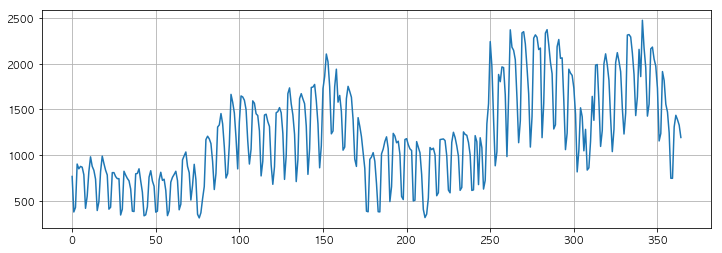

In [82]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

어떤 주기성이 있을 것 같은데 시간 순으로 되어 있는 데이터를 그냥 봐서는 정확하게 잘 모르겠다. 좀 더 정확한 주기성이 있다면 확인해보고싶다.

In [84]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

먼저 시간축(time)을 만들고 웹 트래픽의 자료를 traffic 변수에 저장한다. 지금 우리는 위 그래프를 설명할 간단한 함수를 찾으려고 한다. 그게 직선일 수도 있고 혹은 다항식으로 표현되는 곡선일 수도 있다. 어쨌든 현재 데이터를 간단한 모델로 표현하고 싶다는 뜻이다. 그런 작업을 보통 회귀(regression)라고 한다. 그래서 모델을 1차, 2차, 3차, 15차 다항식으로 표현하고 그 결과를 확인하려 한다.

In [87]:
def error(f,x,y):
    return np.sqrt(np.mean(f(x)-y)**2)

어떤 데이터를 어떤 모델로 표현하려고 하면 그 모델의 적합성을 확인하는 과정이 필요하다. 그러기 위해서는 참 값과 비교해서 에러(error)를 계산해야 한다. 그래서 위의 에러 함수를 정의하였다.

In [89]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

2.94028424135e-13
6.97694565744e-14
5.8805684827e-13
1.04295573393e-05


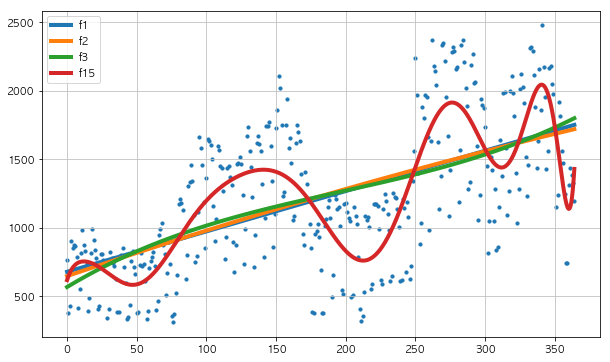

In [90]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')
plt.legend(loc=2)
plt.show()

위 그림에서 데이터를 1,2,3,15차 함수로 표현한 결과를 보자. 1차, 2차, 3차가 정의된 함수에서 에러를 확인해 보니 왜 큰 차이가 없는지 알겠다. 결국 2차나 3차로 표현하려면 그냥 1차로 표현하는 것이 차라리 나아 보인다. 그렇다고 15차 함수를 사용해서 표현하는 것은 과적합(over-fitting)일 수 있다. 어떤 모델을 선택할지는 결국 분석하는 사람의 몫이다. 그러나 위 그림만 가지고는 어떤 결론을 내려야 할지 잘 모르겠다. 우리는 그 뒷부분, 즉 앞으로의 데이터도 예측하고 싶기 때문이다.

## 7-2 Prophet  모듈을 이용한 forecast 예측

Prophet 모듈은 사용법이 아주 간단하다. 위 코드에서 받은 pinkwink_web 변수에서 날짜(index)와 방문수(hit)만 따로 저장한다.

In [98]:
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format="%y. %m. %d.")
del df['date']

m = Prophet(yearly_seasonality=True)
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


그리고 날짜를 pandas가 지원하는 to_datetime 함수를 이용해서 날짜라고 선언한다. 그리고 Prophet 함수를 사용할 때 주기성이 연단위(yearly_seasonality)로 있다고 알려준다.

In [99]:
# 60일간의 데이터를 예측하고 싶다고 make_future_dataframe 명령을 함

future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [103]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,912.016220,709.334738,1121.744880
421,2017-08-26,496.959103,285.042805,712.631724
422,2017-08-27,629.539848,407.017210,833.930089
423,2017-08-28,1182.228340,984.486116,1385.816397
424,2017-08-29,1218.155649,1014.386887,1425.472320


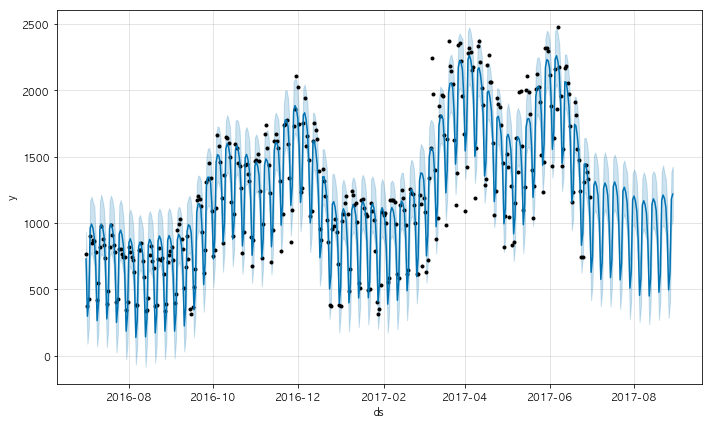

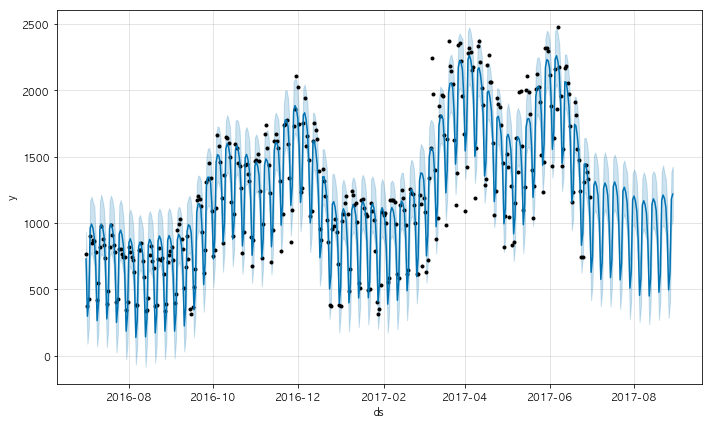

In [104]:
m.plot(forecast)

우리가 받은 2017년 6월 말까지의 데이터 이후 약 2개월의 에측 결과가 나타났다. 단순히 다항식으로 경향을 파악하는 것보다는 나아보인다.

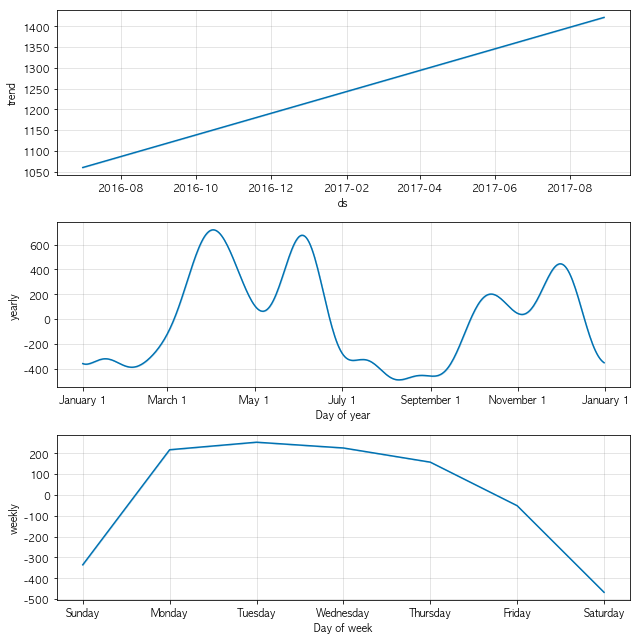

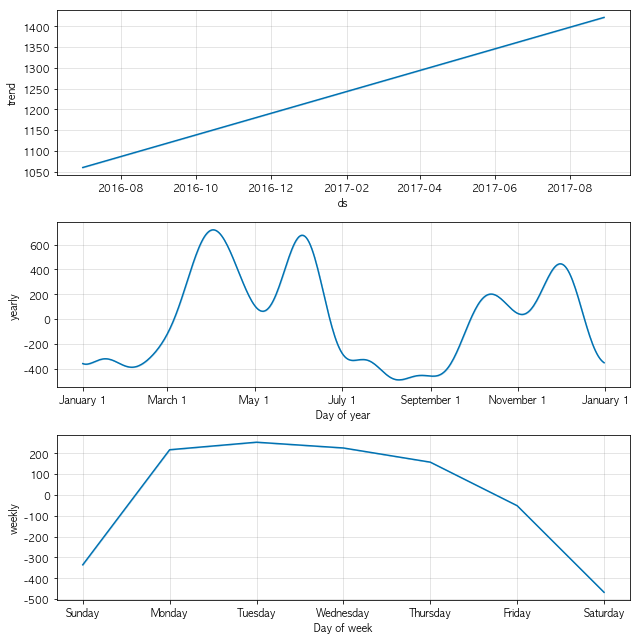

In [105]:
m.plot_components(forecast)

## 7-3 Seasonal 시계열 분석으로 주식 데이터 분석하기

pandas는 구글이 제공하는 주가 정보를 받아올 수 있는 기능이 있다. 바로 DataReader 함수이다. 종목 코드를 알면 한국 kospi 주가 정보도 받아올 수 있다 !!!

In [108]:
# 기아 자동차의 주가 정보 가져오기

from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override()

start_date = '1990-1-1' 
end_date = '2017-6-30' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)


# KIA = web.DataReader('KRX:000270','google',start,end)   구글 용.. 동작이 안 됨..;;
KIA.head()

ModuleNotFoundError: No module named 'fix_yahoo_finance'